In [1]:
import numpy as np
from matplotlib import pyplot as plt
import ctypes
import lmfit
import scipy as sp
import pandas as pd

In [2]:
# import cpp lib for spectrum calculation and initialize argtypes for functions in it

lib = ctypes.CDLL("./getspec.dll", winmode=0)

c_floating = ctypes.c_double;

class c_cfloating(ctypes.Structure): 
    """complex is a c structure
    https://docs.python.org/3/library/ctypes.html#module-ctypes suggests
    to use ctypes.Structure to pass structures (and, therefore, complex)
    """
    _fields_ = [("real", c_floating),("imag", c_floating)]
    @property
    def value(self):
        return self.real+1j*self.imag # fields declared above

c_floating_ptr = ctypes.POINTER(c_floating)
c_cfloating_ptr = ctypes.POINTER(c_cfloating)
c_uint_ptr = ctypes.POINTER(ctypes.c_uint)
c_int = ctypes.c_int

lib.reserve_complex_array.restype = c_cfloating_ptr
lib.reserve_complex_array.argtypes = [ctypes.c_int]
lib.reserve_array.restype = c_floating_ptr
lib.reserve_array.argtypes = [ctypes.c_int]
lib.reserve_twists.restype = c_cfloating_ptr
lib.reserve_twists.argtypes = [ctypes.c_int]
lib.reserve_bitrev.restype = c_uint_ptr
lib.reserve_bitrev.argtypes = [ctypes.c_int]

lib.free_array.restype = None
lib.free_array.argtypes = [c_floating_ptr]
lib.free_complex_array.restype = None
lib.free_complex_array.argtypes = [c_cfloating_ptr]
lib.free_uint_array.restype = None
lib.free_uint_array.argtypes = [c_uint_ptr]


lib.sdeeval.restype = ctypes.c_bool
lib.sdeeval.argtypes = [c_floating_ptr, c_floating_ptr, c_cfloating_ptr, c_cfloating_ptr, c_cfloating_ptr, c_cfloating_ptr,
                        c_cfloating_ptr, c_uint_ptr, c_int, c_int, c_int, c_int, c_floating, 
                        c_floating, c_floating, c_floating, c_floating, c_floating, 
                        c_floating, c_floating, c_floating, c_floating, c_floating]

In [3]:
class fit_assistant:
    def __init__(self, gamma, f0, gain, sigma, averageNum=5, Npow=16, Dt=1e-6, tau=1e-4, offset=0.2):
        
        #self.gamma = gamma
        #self.f0 = f0
        #self.gain = gain
        #self.sigma = sigma
        self.Nav = averageNum
        self.Npow = Npow
        self.Dt = Dt
        self.tau = tau
        self.offset = offset
        self.tauDt = round(np.floor(tau/Dt));
        if self.tauDt < 1:
            self.tauDt = 1
        self.tau = self.tauDt * self.Dt;  # fix tau in order to make it right value
        self.L = 2**self.Npow

        self.skip = round(self.offset * self.L);  # how many dots will be skipped by offset

        self.freqs = np.linspace(-1/2/tau, 1/2/tau, self.L)
        self.fstep = self.freqs[1] - self.freqs[0]
        self.max_freq = np.max(self.freqs)
        
        # reserve memory for sde evaluation
        self.twist = lib.reserve_twists(self.Npow)
        self.bitrev = lib.reserve_bitrev(self.Npow)
        self.Ex = lib.reserve_complex_array(self.L)
        self.Ey = lib.reserve_complex_array(self.L)
        self.tmpEx = lib.reserve_complex_array(self.L)
        self.tmpEy = lib.reserve_complex_array(self.L)
        self.specx = lib.reserve_array(self.L)
        self.specy = lib.reserve_array(self.L)
        
        self.spx = np.ctypeslib.as_array(self.specx, (self.L,))
        self.spy = np.ctypeslib.as_array(self.specy, (self.L,))
        
        self.specxloginterp = None
        self.specyloginterp = None
        self.was_evaluated = False
        self.prev_comp_result = True
        
        self.parameters = lmfit.create_params(gamma={'value' : gamma, 'min' : 0.0},
                                              f0={'value' : f0},
                                              gain={'value' : gain},
                                              sigma={'value' : sigma, 'min' : 0.0})
        self.fit_func_call_num = 0
        
        
    def __del__(self):
        # free all memory
        lib.free_complex_array(self.Ex)
        lib.free_complex_array(self.Ey)
        lib.free_complex_array(self.tmpEx)
        lib.free_complex_array(self.tmpEy)
        lib.free_complex_array(self.twist)
        lib.free_array(self.specx)
        lib.free_array(self.specy)
        lib.free_uint_array(self.bitrev)
        
    
    def get_max_freq(self):
        return self.max_freq
    
    
    def compute_raw_spectrum(self, alpha, kappa, gamma_d, gamma_a, gamma_p, beta, mu, C_sp, N_rel):
        self.fit_func_call_num = self.fit_func_call_num + 1
        print("Call number : {}".format(self.fit_func_call_num))
        self.prev_comp_result = lib.sdeeval(self.specx, self.specy, self.Ex, self.Ey, self.tmpEx, self.tmpEy, 
            self.twist, self.bitrev, self.Npow, self.skip, self.Nav, self.tauDt, self.Dt, 
            alpha, kappa, 1.0, gamma_d, gamma_a, 
            gamma_p, beta, mu, C_sp, N_rel);
        # spx = np.copy(np.ctypeslib.as_array(specx, (L,)))
        # spy = np.copy(np.ctypeslib.as_array(specy, (L,)))
        # return [spx, spy]
    
    
    def internal_fit_util(self, params, frequencies=None, datax=None, datay=None):
        # data MUST be provided in logarithmic10 scale
        parvals = params.valuesdict()
        ext_f0 = parvals['f0']
        ext_gamma = parvals['gamma']
        ext_gain = parvals['gain']
        ext_sigma = parvals['sigma']
        spxgauss = sp.interpolate.interp1d(self.freqs, np.log10(sp.ndimage.gaussian_filter1d(self.spx, ext_sigma / self.fstep, mode="constant", cval=0.0)))
        spygauss = sp.interpolate.interp1d(self.freqs, np.log10(sp.ndimage.gaussian_filter1d(self.spy, ext_sigma / self.fstep, mode="constant", cval=0.0)))
        errx = datax - ext_gain - spxgauss((frequencies - ext_f0) / ext_gamma)
        erry = datay - ext_gain - spygauss((frequencies - ext_f0) / ext_gamma)
        return np.reshape([errx, erry], -1)
        
        
    def fit_internal(self, frequencies, datax, datay, recalculate_start_pts=True):
        """
        Fits internal parametres (f0, gain, gamma, sigma) assuming spectra already have been calculated 
        and accumulated in self.speci
        Data MUST be provided in log10 scale
        """
        if recalculate_start_pts:
            mfdx = frequencies[np.argmax(datax)]
            mfdy = frequencies[np.argmax(datay)]
            mfx = self.freqs[np.argmax(self.spx)]
            mfy = self.freqs[np.argmax(self.spy)]
            deltaf = np.max(frequencies) - np.min(frequencies)
            if abs(mfx - mfy) < 1e-4:
                # TODO : get other maxima
                return True
            self.parameters['gamma'].set( (mfdy - mfdx) / (mfy - mfx), min=0.01, vary=False )
            if (mfdy - mfdx) / (mfy - mfx) < 0.01:
                return True
            f0 = (mfy*mfdx - mfdy*mfx) / (mfy - mfx)
            self.parameters['f0'].set( value=f0, min=f0-deltaf/4, max=f0+deltaf/4 )
            self.parameters['gain'].set( (np.max(datax) - np.log10(np.max(self.spx)) + np.max(datay) - np.log10(np.max(self.spy))) / 2 )
            self.parameters['sigma'].set( 0.75, min=0.0, vary=False )
            
        
        fit_result = lmfit.minimize(self.internal_fit_util, self.parameters, kws={'frequencies':frequencies, 'datax':datax, 'datay':datay})
        self.parameters = fit_result.params
        self.specxloginterp = sp.interpolate.interp1d(self.freqs*self.parameters['gamma'].value + self.parameters['f0'].value, 
                                                      self.parameters['gain'].value + np.log10(sp.ndimage.gaussian_filter1d(self.spx, self.parameters['sigma'].value / self.fstep / self.parameters['gamma'].value, 
                                                                                                         mode="constant", cval=0.0)))
        self.specyloginterp = sp.interpolate.interp1d(self.freqs*self.parameters['gamma'].value + self.parameters['f0'].value, 
                                                      self.parameters['gain'].value + np.log10(sp.ndimage.gaussian_filter1d(self.spy, self.parameters['sigma'].value / self.fstep / self.parameters['gamma'].value, 
                                                                                                         mode="constant", cval=0.0)))
        self.was_evaluated = True
        
        return False
            
        
def fit_difference(pars, fit_assistant=None, frequencies=None, datax=None, datay=None, mu=None):
    # Data MUST be providen in log10 scale
    if fit_assistant is None:
        print("Fit assistant is not provided. Aborting")
        return None
    if (datax is None) or (datay is None) or (frequencies is None):
        print("No data providen for fit. Aborting")
        return None
    parvals = pars.valuesdict()
    alpha = parvals['alpha']
    kappa = parvals['kappa']
    gamma_d = parvals['gamma_d']
    gamma_a = parvals['gamma_a']
    gamma_p = parvals['gamma_p']
    beta = parvals['beta']
    C_sp = parvals['C_sp']
    N_rel = parvals['N_rel']
    if mu is None:
        mu = parvals['mu']
    
    fit_assistant.compute_raw_spectrum(alpha, kappa, gamma_d, gamma_a, gamma_p, beta, mu, C_sp, N_rel)
    if not(fit_assistant.prev_comp_result):
        return 100*np.reshape([datax, datay], -1)**2
    ret = fit_assistant.fit_internal(frequencies, datax, datay, recalculate_start_pts=True)
    if ret:
        return 100*np.reshape([datax, datay], -1)**2
    errx = datax - fit_assistant.specxloginterp(frequencies)
    erry = datay - fit_assistant.specyloginterp(frequencies)
    return np.reshape([errx, erry], -1)**2

In [4]:
def read_spectrum_csv(path):
    with open(path, 'r') as file:
        next(file)
        next(file)
        start = int(next(file))
        file.close()
        return pd.read_csv(path, skiprows=start+4, names=["Frequency", "Level"], usecols=[0,1]).to_numpy()

In [5]:
Ith = 1.2582  # mA
dataX = read_spectrum_csv("../Experiments/25.05.23/X450mA.CSV")
dataY = read_spectrum_csv("../Experiments/25.05.23/Y450mA.CSV")
specX = dataX[:,1] / 10
specY = dataY[:,1] / 10
freqs = dataX[:,0] * 1000

N_rel = 0.938
mutilde = 4.5 / Ith

alpha = 3.;
kappa = 80.;
gamma = 1.;
gamma_d = 1000.;
gamma_a =  2.5;
gamma_p = 2*np.pi*9;
beta = 0.;
mu = (mutilde - N_rel) / (1 - N_rel);

C_sp = 5e-4;
N_th = 6.25e6;
N_tr = N_th * N_rel;

Dt = 1e-6;
tau = 1e-4;
offset = 0.2;
Nav = 5;

assistant = fit_assistant(gamma, 194870., 1., 0.75, averageNum=3, Npow=16, Dt=1e-6, tau=1e-4, offset=0.2)
maxf = assistant.get_max_freq()

params = lmfit.create_params(alpha={'value':alpha, 'min':0.0, 'max':10.0},
                             kappa={'value':kappa, 'min':0.0, 'max':10000.0},
                             gamma_d={'value':gamma_d, 'min':0.0, 'max':30000.0},
                             gamma_a={'value':gamma_a, 'min':0.0, 'max':100.0},
                             gamma_p={'value':gamma_p, 'min':0.0, 'max':10000.0},
                             beta={'value':beta, 'min':-np.pi, 'max':np.pi},
                             mutilde={'value':mutilde, 'vary':False},
                             mu={'expr':"(mutilde - N_rel) / (1 - N_rel)"},
                             C_sp={'value':C_sp, 'min':0.0, 'max':1e-4},
                             N_rel={'value':N_rel, 'min':0.0, 'max':1.0}) 

In [6]:
%%time
res = lmfit.minimize(fit_difference, params, kws={'fit_assistant':assistant, 'frequencies':freqs, 'datax':specY, 'datay':specX}, 
                     calc_covar=False, method="dual_annealing", max_nfev=1000)

Call number : 1
Call number : 2
Call number : 3
Call number : 4
Call number : 5
Call number : 6
Call number : 7
Call number : 8
Call number : 9
Call number : 10
Call number : 11
Call number : 12
Call number : 13
Call number : 14
Call number : 15
Call number : 16
Call number : 17
Call number : 18
Call number : 19
Call number : 20
Call number : 21
Call number : 22
Call number : 23
Call number : 24
Call number : 25
Call number : 26


C:\Users\dedko\AppData\Local\Programs\Python\Python39\lib\site-packages\asteval\astutils.py:265: RuntimeWarning: divide by zero encountered in double_scalars
  ast.Div: lambda a, b: a / b,


Call number : 27
Call number : 28
Call number : 29
Call number : 30
Call number : 31
Call number : 32
Call number : 33
Call number : 34
Call number : 35
Call number : 36
Call number : 37
Call number : 38
Call number : 39
Call number : 40
Call number : 41
Call number : 42
Call number : 43
Call number : 44
Call number : 45
Call number : 46
Call number : 47
Call number : 48
Call number : 49
Call number : 50
Call number : 51
Call number : 52
Call number : 53
Call number : 54
Call number : 55
Call number : 56
Call number : 57
Call number : 58
Call number : 59
Call number : 60
Call number : 61
Call number : 62
Call number : 63
Call number : 64
Call number : 65
Call number : 66
Call number : 67
Call number : 68
Call number : 69
Call number : 70
Call number : 71
Call number : 72
Call number : 73
Call number : 74
Call number : 75
Call number : 76
Call number : 77
Call number : 78
Call number : 79
Call number : 80
Call number : 81
Call number : 82
Call number : 83
Call number : 84
Call number : 

Call number : 487
Call number : 488
Call number : 489
Call number : 490
Call number : 491
Call number : 492
Call number : 493
Call number : 494
Call number : 495
Call number : 496
Call number : 497
Call number : 498
Call number : 499
Call number : 500
Call number : 501
Call number : 502
Call number : 503
Call number : 504
Call number : 505
Call number : 506
Call number : 507
Call number : 508
Call number : 509
Call number : 510
Call number : 511
Call number : 512
Call number : 513
Call number : 514
Call number : 515
Call number : 516
Call number : 517
Call number : 518
Call number : 519
Call number : 520
Call number : 521
Call number : 522
Call number : 523
Call number : 524
Call number : 525
Call number : 526
Call number : 527
Call number : 528
Call number : 529
Call number : 530
Call number : 531
Call number : 532
Call number : 533
Call number : 534
Call number : 535
Call number : 536
Call number : 537
Call number : 538
Call number : 539
Call number : 540
Call number : 541
Call numbe

Call number : 945
Call number : 946
Call number : 947
Call number : 948
Call number : 949
Call number : 950
Call number : 951
Call number : 952
Call number : 953
Call number : 954
Call number : 955
Call number : 956
Call number : 957
Call number : 958
Call number : 959
Call number : 960
Call number : 961
Call number : 962
Call number : 963
Call number : 964
Call number : 965
Call number : 966
Call number : 967
Call number : 968
Call number : 969
Call number : 970
Call number : 971
Call number : 972
Call number : 973
Call number : 974
Call number : 975
Call number : 976
Call number : 977
Call number : 978
Call number : 979
Call number : 980
Call number : 981
Call number : 982
Call number : 983
Call number : 984
Call number : 985
Call number : 986
Call number : 987
Call number : 988
Call number : 989
Call number : 990
Call number : 991
Call number : 992
Call number : 993
Call number : 994
Call number : 995
Call number : 996
Call number : 997
Call number : 998
Call number : 999
Call numbe

In [ ]:
assistant.compute_raw_spectrum(alpha, kappa, gamma_d, gamma_a, gamma_p, beta, mu, C_sp, N_rel)

In [ ]:
assistant.fit_internal(freqs, specY, specX, recalculate_start_pts=True)

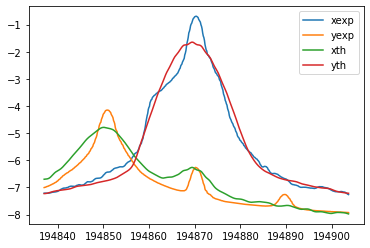

In [7]:
plt.plot(freqs, specX, label="xexp")
plt.plot(freqs, specY, label="yexp")
plt.plot(freqs, assistant.specxloginterp(freqs), label="xth")
plt.plot(freqs, assistant.specyloginterp(freqs), label="yth")
plt.legend()
plt.show()

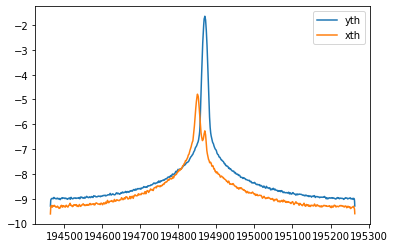

In [8]:
ffs = assistant.parameters['f0'].value + assistant.parameters['gamma'].value* np.linspace(-1/2/1e-4, 1/2/1e-4, 10000)
plt.plot(ffs, assistant.specyloginterp(ffs), label="yth")
plt.plot(ffs, assistant.specxloginterp(ffs), label="xth")
plt.legend()

In [9]:
assistant.parameters

name,value,standard error,relative error,initial value,min,max,vary
gamma,0.08004369,0.00000000,(0.00%),0.08004368667916968,0.01000000,inf,False
f0,194863.624,0.00849963,(0.00%),194864.5789399625,194847.904,194881.254,True
gain,-9.04170429,0.01157638,(0.13%),-9.212213659657014,-inf,inf,True
sigma,0.75000000,0.00000000,(0.00%),0.75,0.00000000,inf,False


In [10]:
res.params.valuesdict()

{'alpha': 8.769660892430693,
 'kappa': 4401.836677998304,
 'gamma_d': 23845.017646254506,
 'gamma_a': 80.3281773882918,
 'gamma_p': 9561.84006917823,
 'beta': -1.9590301802680052,
 'mutilde': 3.57653791130186,
 'mu': 12.903997827342144,
 'C_sp': 7.231046733327358e-06,
 'N_rel': 0.7835569235921866}

In [11]:
res

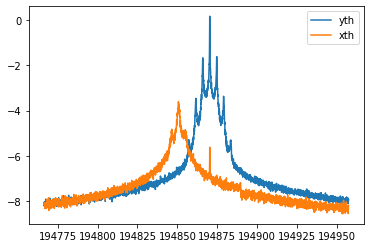

In [18]:
ffs = assistant.parameters['f0'].value + assistant.parameters['gamma'].value* np.linspace(-1/4/1e-4, 1/4/1e-4, 10000)
plt.plot(ffs, assistant.specyloginterp(ffs), label="yth")
plt.plot(ffs, assistant.specxloginterp(ffs), label="xth")
plt.legend()

In [17]:
# dual_annealing gamma > 0.1 500 iter
res.params.valuesdict()

{'alpha': 5.462372634791897,
 'kappa': 7359.758685757395,
 'gamma_d': 29353.651149600442,
 'gamma_a': 36.3492675006604,
 'gamma_p': 1581.0760263206116,
 'beta': 3.0839126642089254,
 'mutilde': 3.57653791130186,
 'mu': 36.289570909635685,
 'C_sp': 8.731646530718509e-05,
 'N_rel': 0.9269886868871408}

In [15]:
res

In [23]:
assistant.parameters

name,value,standard error,relative error,initial value,min,max,vary
gamma,0.03812626,0.00000000,(0.00%),0.038126260053617016,0.01000000,inf,False
f0,194861.898,0.00674494,(0.00%),194861.95797587134,194845.283,194878.633,True
gain,-9.69200088,0.01514827,(0.16%),-10.948057549828137,-inf,inf,True
sigma,0.75000000,0.00000000,(0.00%),0.75,0.00000000,inf,False


In [24]:
assistant.parameters['sigma'].set(1.5, vary=False)

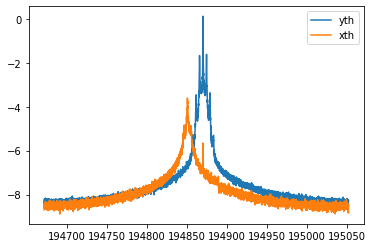

In [26]:
ffs = assistant.parameters['f0'].value + assistant.parameters['gamma'].value* np.linspace(-1/2/1e-4, 1/2/1e-4, 10000)
plt.plot(ffs, assistant.specyloginterp(ffs), label="yth")
plt.plot(ffs, assistant.specxloginterp(ffs), label="xth")
plt.legend()

In [58]:
dds = fit_difference(res.params, fit_assistant=assistant, frequencies=freqs, datax=specY, datay=specX)

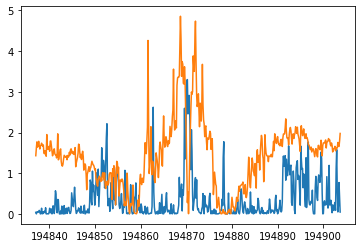

In [59]:
plt.plot(freqs, dds[0:freqs.shape[0]], freqs, dds[freqs.shape[0]:2*freqs.shape[0]])

In [8]:
assistant.parameters

name,value,standard error,relative error,initial value,min,max,vary
gamma,0.01000000,0.00000000,(0.00%),-0.005729691780821575,0.01000000,inf,False
f0,194860.741,0.00815342,(0.00%),194860.7391624285,194844.064,194877.414,True
gain,-7.64968047,0.04178019,(0.55%),-10.56747659559248,-inf,inf,True
sigma,0.75000000,0.00000000,(0.00%),0.75,0.00000000,inf,False


In [10]:
res.params.valuesdict()

{'alpha': 2.999997285724079,
 'kappa': 80.00041112313505,
 'gamma_d': 999.9415232863535,
 'gamma_a': 2.500009162848121,
 'gamma_p': 56.547247437009894,
 'beta': 3.2222343016030663e-07,
 'mutilde': 3.57653791130186,
 'mu': 42.55698458984797,
 'C_sp': 9.999999999998259e-05,
 'N_rel': 0.9379998828901728}

In [16]:
res

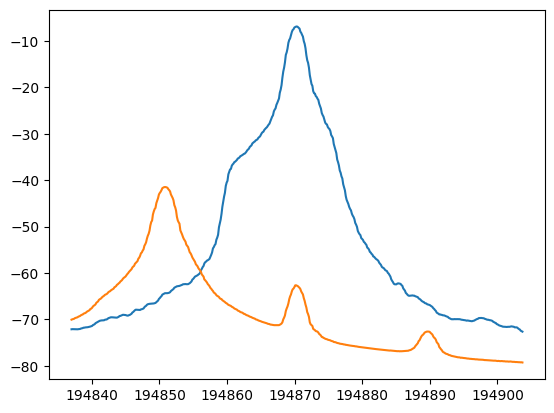

In [56]:
plt.plot(freqs, specX, freqs, specY)
plt.show()

In [82]:
(4.5/1.25-0.95)/0.05

53.00000000000001

In [77]:
ss = 1.23
pps = lmfit.create_params(gamma={'value' : ss, 'min' : 0.0}, psi={'expr':"I_th*gamma"}, I_th={'value':Ith, 'vary':False})

In [78]:
pps['gamma'].set(1.34)

In [79]:
pps

name,value,initial value,min,max,vary,expression
gamma,1.34000000,1.34,0.00000000,inf,True,
psi,1.68598800,-inf,-inf,inf,False,I_th*gamma
I_th,1.25820000,1.2582,-inf,inf,False,


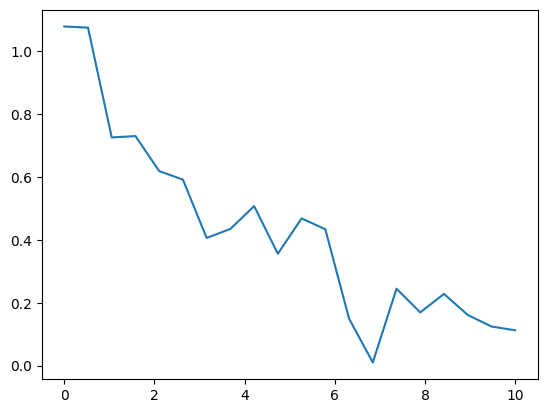

In [80]:
def tstfunc(params, x=None, data=None):
    parvals = params.valuesdict()
    ext_gamma = parvals['gamma']
    return data - np.exp(-ext_gamma * x)

# pps = lmfit.create_params(gamma={'value' : ss, 'min' : 0.0})
x = np.linspace(0, 10, 20)
y = np.exp(-0.2 * x) + np.random.normal(scale=0.1, size=x.shape)

res = lmfit.minimize(tstfunc, pps, kws={'x':x, 'data':y})

plt.plot(x,y)

In [81]:
res